In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-94163424-3197-fc1b-f840-2b99901086d0)


In [2]:
import pandas as pd
import os
import yfinance as yf

def getData():

    if os.path.exists('data.csv'):
        df = pd.read_csv('data.csv', index_col=0)
    else:
        df = yf.download('^NSEI', start="2011-01-01", end="2023-12-31", interval="1d")
        df.to_csv('data.csv')

In [3]:
getData()

[*********************100%%**********************]  1 of 1 completed


In [4]:
df = pd.read_csv("data.csv", parse_dates=["Date"], index_col=["Date"])
# df = pd.read_csv("data.csv")

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,6177.450195,6178.549805,6147.200195,6157.600098,6157.600098,0
2011-01-04,6172.750000,6181.049805,6124.399902,6146.350098,6146.350098,0
2011-01-05,6141.350098,6141.350098,6062.350098,6079.799805,6079.799805,0
2011-01-06,6107.000000,6116.149902,6022.299805,6048.250000,6048.250000,0
2011-01-07,6030.899902,6051.200195,5883.600098,5904.600098,5904.600098,0


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700
2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500
2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500
2023-12-28,21715.000000,21801.449219,21678.000000,21778.699219,21778.699219,393100
2023-12-29,21737.650391,21770.300781,21676.900391,21731.400391,21731.400391,270900


In [8]:
df.shape

(3184, 6)

In [9]:
nifty_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
nifty_prices.head()


,Price
Date,
2011-01-03,6157.600098
2011-01-04,6146.350098
2011-01-05,6079.799805
2011-01-06,6048.250000
2011-01-07,5904.600098


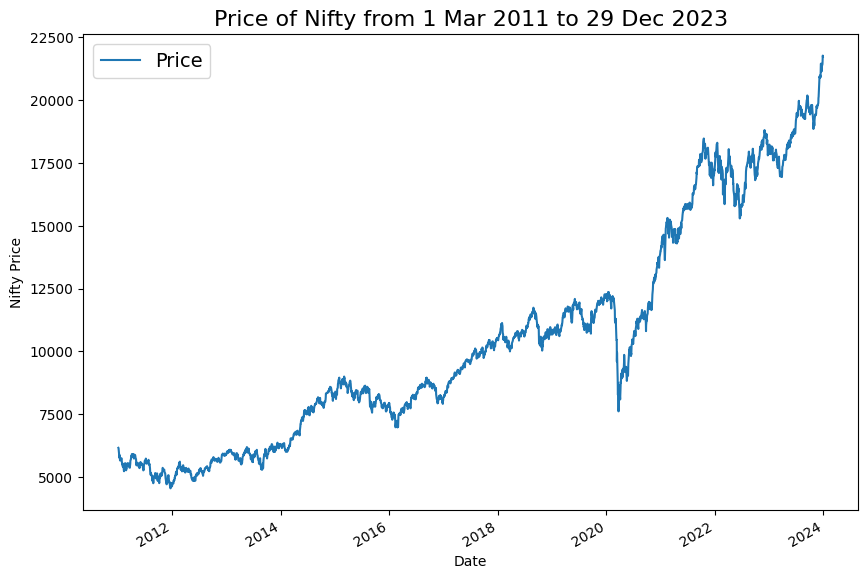

In [10]:
import matplotlib.pyplot as plt
nifty_prices.plot(figsize=(10, 7))
plt.ylabel("Nifty Price")
plt.title("Price of Nifty from 1 Mar 2011 to 29 Dec 2023", fontsize=16)
plt.legend(fontsize=14)

In [11]:
timesteps = nifty_prices.index.to_numpy()
prices = nifty_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2011-01-03T00:00:00.000000000', '2011-01-04T00:00:00.000000000',
        '2011-01-05T00:00:00.000000000', '2011-01-06T00:00:00.000000000',
        '2011-01-07T00:00:00.000000000', '2011-01-10T00:00:00.000000000',
        '2011-01-11T00:00:00.000000000', '2011-01-12T00:00:00.000000000',
        '2011-01-13T00:00:00.000000000', '2011-01-14T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([6157.60009766, 6146.35009766, 6079.79980469, 6048.25      ,
        5904.60009766, 5762.85009766, 5754.10009766, 5863.25      ,
        5751.89990234, 5654.54980469]))

In [12]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2547, 637, 2547, 637)

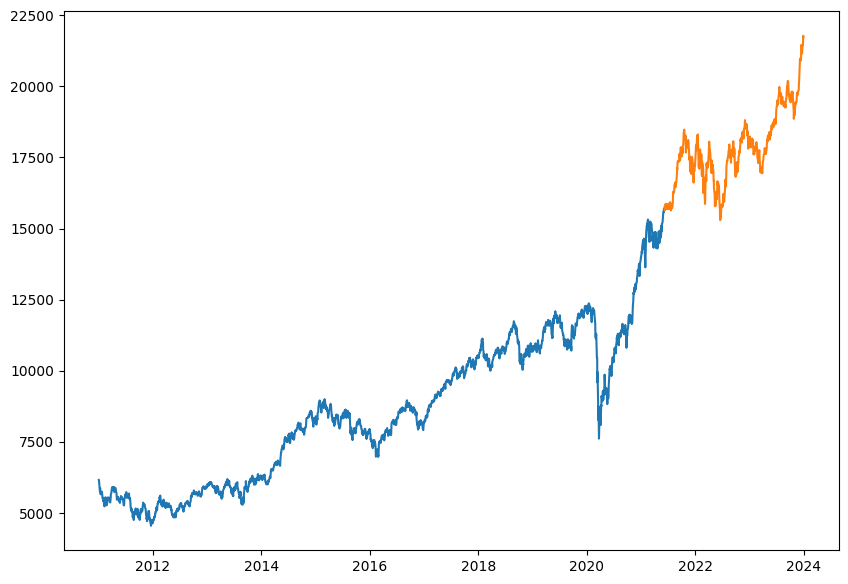

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(X_train,y_train)
plt.plot(X_test,y_test)
# plt.figsize(10,7)

In [14]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Nifty Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

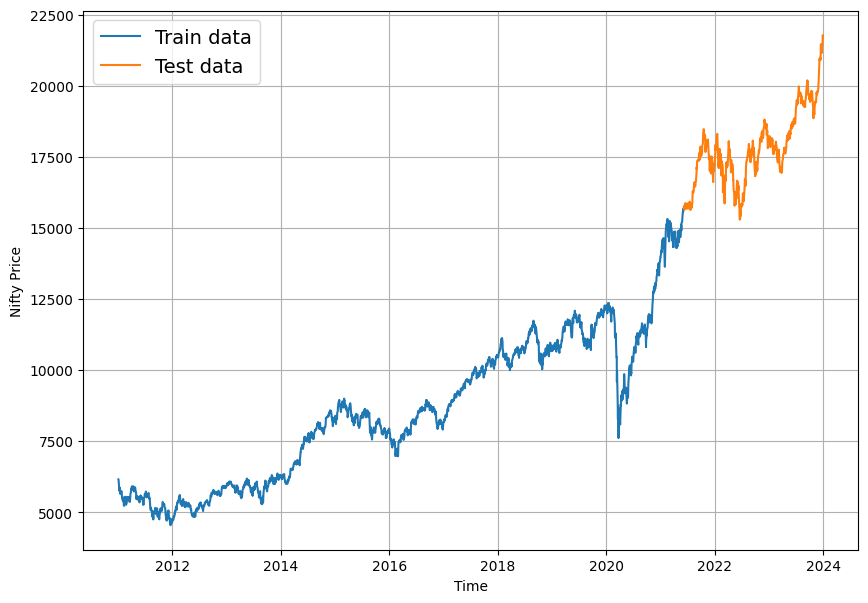

In [15]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train,format = '-', label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format = '-',label="Test data")

In [16]:
import tensorflow as tf

In [17]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [18]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [19]:
import numpy as np

In [20]:
WINDOW_SIZE = 7
HORIZON = 1

In [21]:
def get_labelled_windows(x, horizon=1):

  return x[:, :-horizon], x[:, -horizon:]

In [22]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [23]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3177, 3177)

In [24]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [25]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2541, 636, 2541, 636)

In [26]:
import os
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu",input_shape=[7]),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it



## Model 1 with window size 7

In [28]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
20/20 [==============================] - 3s 40ms/step - loss: 2795.2903 - mae: 2795.2903 - val_loss: 2340.2444 - val_mae: 2340.2444
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 471.6132 - mae: 471.6132 - val_loss: 646.5446 - val_mae: 646.5446
Epoch 3/100
20/20 [==============================] - 0s 23ms/step - loss: 162.2623 - mae: 162.2623 - val_loss: 244.5999 - val_mae: 244.5999
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 116.1927 - mae: 116.1927 - val_loss: 192.0662 - val_mae: 192.0662
Epoch 5/100
20/20 [==============================] - 0s 22ms/step - loss: 110.9498 - mae: 110.9498 - val_loss: 191.5047 - val_mae: 191.5047
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 111.0809 - mae: 111.0809 - val_loss: 192.2914 - val_mae: 192.2914
Epoch 7/100
20/20 [==============================] - 0s 22ms/step - loss: 113.6004 - mae: 113.6004 - val_loss: 190.3371 - val_mae: 190.3371
Epoch 8/100
20/20

In [30]:
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 139.5942 - mae: 139.5942


[139.5941925048828, 139.5941925048828]

In [31]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 134.3256 - mae: 134.3256


[134.3256378173828, 134.3256378173828]

In [32]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [33]:
model_1_preds = make_preds(model_1,
                           input_data=test_windows)

20/20 [==============================] - 0s 2ms/step


In [34]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_1_preds)
model_1_results

{'mae': 134.32564,
 'mse': 31648.5,
 'rmse': 177.90025,
 'mape': 0.7636591,
 'mase': 1.1735303}

## Model 2 with Window Size = 30 and Horizon = 1

In [35]:
prices.shape

(3184,)

In [36]:
full_windows, full_labels = make_windows(prices, window_size=30, horizon=1)
len(full_windows), len(full_labels)

(3154, 3154)

In [37]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2523, 631, 2523, 631)

In [38]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu",input_shape=[30]),
  layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

In [39]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [41]:
model_2.fit(x=train_windows,y = train_labels,epochs=100,batch_size=128,validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
20/20 [==============================] - 2s 35ms/step - loss: 3758.6289 - mae: 3758.6289 - val_loss: 3081.2820 - val_mae: 3081.2820
Epoch 2/100
20/20 [==============================] - 0s 24ms/step - loss: 628.2187 - mae: 628.2187 - val_loss: 556.1548 - val_mae: 556.1548
Epoch 3/100
20/20 [==============================] - 1s 51ms/step - loss: 274.8862 - mae: 274.8862 - val_loss: 496.9595 - val_mae: 496.9595
Epoch 4/100
20/20 [==============================] - 1s 32ms/step - loss: 237.5437 - mae: 237.5437 - val_loss: 440.1097 - val_mae: 440.1097
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 225.7805 - mae: 225.7805 - val_loss: 450.0056 - val_mae: 450.0056
Epoch 6/100
20/20 [==============================] - 1s 29ms/step - loss: 219.8806 - mae: 219.8806 - val_loss: 383.2783 - val_mae: 383.2783
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 212.1754 - mae: 212.1754 - val_loss: 365.8677 - val_mae: 365.8677
Epoch 8/100
20/20

In [42]:
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 155.9352 - mae: 155.9352


[155.93524169921875, 155.93524169921875]

In [43]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 155.9352 - mae: 155.9352


[155.93524169921875, 155.93524169921875]

In [44]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

20/20 [==============================] - 0s 1ms/step


In [45]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 155.93524,
 'mse': 41204.957,
 'rmse': 202.99004,
 'mape': 0.88474137,
 'mase': 1.3579216}

## Model 3 with Horizon 7 and window size 30

In [46]:
full_windows, full_labels = make_windows(prices, window_size=30, horizon=7)
len(full_windows), len(full_labels)

(3148, 3148)

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [48]:
train_labels.shape

(2518, 7)

In [49]:
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu",input_shape=[30]),
  layers.Dense(7, activation="linear")
], name="model_3_dense")

In [50]:
model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3968      
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 4871 (19.03 KB)
Trainable params: 4871 (19.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [52]:
model_3.fit(x=train_windows,y = train_labels,epochs=100,batch_size=128,validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
20/20 [==============================] - 1s 30ms/step - loss: 4182.0713 - mae: 4182.0713 - val_loss: 1525.9254 - val_mae: 1525.9254
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 643.4681 - mae: 643.4681 - val_loss: 750.1879 - val_mae: 750.1879
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 317.7124 - mae: 317.7124 - val_loss: 520.1983 - val_mae: 520.1983
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 263.4655 - mae: 263.4655 - val_loss: 480.2318 - val_mae: 480.2318
Epoch 5/100
20/20 [==============================] - 0s 23ms/step - loss: 255.3613 - mae: 255.3613 - val_loss: 475.8607 - val_mae: 475.8607
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 251.1853 - mae: 251.1853 - val_loss: 468.0651 - val_mae: 468.0651
Epoch 7/100
20/20 [==============================] - 0s 23ms/step - loss: 245.7094 - mae: 245.7094 - val_loss: 461.4042 - val_mae: 461.4042
Epoch 8/100
20/2

In [53]:
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 297.9694 - mae: 297.9694


[297.9693908691406, 297.9693908691406]

In [54]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 284.5318 - mae: 284.5318


[284.5317687988281, 284.5317687988281]

In [55]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

20/20 [==============================] - 0s 2ms/step


In [56]:
model_3_preds.shape

TensorShape([630, 7])

In [57]:
tf.squeeze(test_labels).shape

TensorShape([630, 7])

In [58]:
model_3_results = evaluate_preds(y_true=(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  40.178852,   55.393833,   91.72224 ,  106.27051 ,  107.84417 ,
         155.43094 ,  159.80412 ,  179.72475 ,  135.10408 ,   53.026924,
          73.2959  ,  101.31236 ,  118.99414 ,  138.66043 ,  104.543945,
          92.38044 ,   95.48131 ,   73.34794 ,   88.89537 ,  113.74944 ,
         101.28571 ,  114.512276,  112.956474,   63.978794,   75.76953 ,
         120.895226,  121.918945,  124.97823 ,  132.2698  ,  171.33008 ,
         135.1995  ,   99.73633 ,  126.73242 ,  134.14119 ,  150.08371 ,
         142.20676 ,  202.44545 ,  295.06598 ,  355.80957 ,  356.76492 ,
         331.78793 ,  264.18652 ,  228.12025 ,  240.45662 ,  236.09166 ,
         219.96777 ,  185.43596 ,  166.66922 ,  137.74623 ,   80.86552 ,
          60.27232 ,  102.14034 ,  159.89787 ,  218.22713 ,  240.71819 ,
         297.50082 ,  391.66406 ,  453.22516 ,  430.35352 ,  370.9615  ,
         351.53012 ,  281.2793  ,  239.47935 ,  173.56027 ,  144.64648 ,
          90.02706 ,   78.63421 ,  117.21373

In [59]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 284.53177,
 'mse': 141044.81,
 'rmse': 322.08694,
 'mape': 1.6165715,
 'mase': 2.481664}

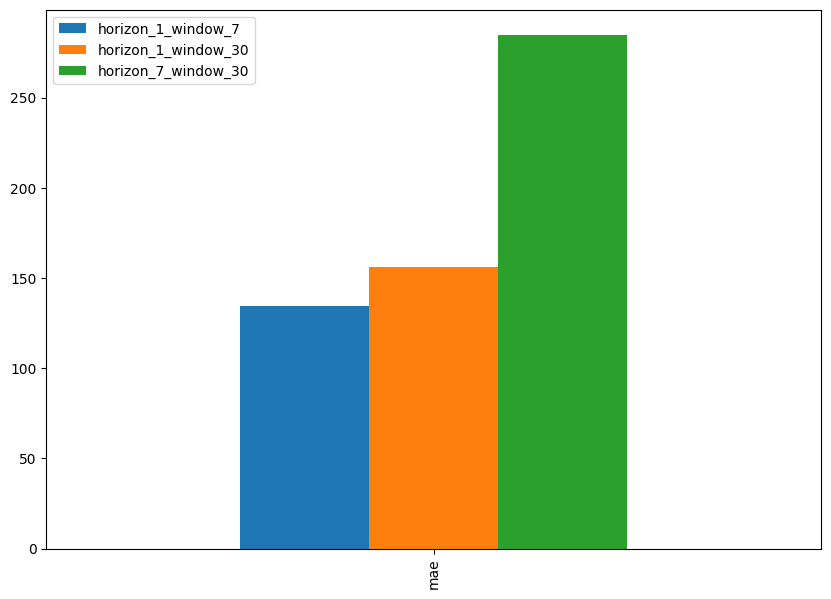

In [61]:
pd.DataFrame({
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4 CNN


In [62]:
full_windows, full_labels = make_windows(prices, window_size=7, horizon=1)
len(full_windows), len(full_labels)

(3177, 3177)

In [63]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2541, 636, 2541, 636)

In [64]:
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Input(shape=[7]),
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

In [65]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [67]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 152.0704


152.0703887939453

In [68]:
model_4_preds = make_preds(model_4,
                           input_data=test_windows)

20/20 [==============================] - 0s 2ms/step


In [69]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 152.07039,
 'mse': 38959.98,
 'rmse': 197.38283,
 'mape': 0.8633542,
 'mase': 1.3285567}

## LSTM and Functional API

In [70]:
inputs = layers.Input(shape=7)
x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
# x = layers.LSTM(128,return_sequences=True)(x)
x = layers.LSTM(128,activation="relu")(x)
# x = layers.Dense(32,activation="relu")(x)
output = layers.Dense(1)(x)

model_5 = tf.keras.Model(inputs=inputs,outputs=output , name = "model_5_LSTM")

model_5.compile(loss="mae",optimizer=tf.keras.optimizers.Adam())
# model_5.fit()
model_5.fit(train_windows,train_labels,epochs=100,batch_size=128,validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])



Epoch 1/100
20/20 [==============================] - 3s 87ms/step - loss: 6528.1826 - val_loss: 10821.4492
Epoch 2/100
20/20 [==============================] - 1s 75ms/step - loss: 3880.1191 - val_loss: 4529.9209
Epoch 3/100
20/20 [==============================] - 1s 74ms/step - loss: 878.2958 - val_loss: 1019.2801
Epoch 4/100
20/20 [==============================] - 2s 94ms/step - loss: 226.7798 - val_loss: 342.9217
Epoch 5/100
20/20 [==============================] - 2s 102ms/step - loss: 136.6894 - val_loss: 233.0785
Epoch 6/100
20/20 [==============================] - 2s 83ms/step - loss: 125.1818 - val_loss: 217.1417
Epoch 7/100
20/20 [==============================] - 1s 74ms/step - loss: 124.2753 - val_loss: 213.0864
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 123.0961 - val_loss: 214.1935
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 122.9145 - val_loss: 213.3515
Epoch 10/100
20/20 [==============================] - 1s 74

In [71]:
model_5.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 175.7522


175.75216674804688

In [72]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 175.7522


175.75216674804688

In [73]:
# model_5.summary()

In [74]:
model_5_preds = make_preds(model_5,
                           input_data=test_windows)

20/20 [==============================] - 0s 2ms/step


In [75]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 175.75215,
 'mse': 53421.75,
 'rmse': 231.13145,
 'mape': 0.9983127,
 'mase': 1.5354513}

## N-Beats Algorithm

In [76]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,input_size:int , theta_size:int, horizon: int, n_neurons: int , n_layers: int,**kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons,activation = "relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation="linear",name = "theta")

  def call(self,inputs):
    x = inputs
    for l in self.hidden:
      x = l(x)
    theta = self.theta_layer(x)

    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


In [77]:
nifty_prices_nbeats = nifty_prices.copy()
for i in range(7):
  nifty_prices_nbeats["Price "+str(i+1)] = nifty_prices_nbeats["Price"].shift(periods=i+1)
nifty_prices_nbeats.dropna(inplace=True)

In [78]:
nifty_prices_nbeats

,Price,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,
2011-01-12,5863.250000,5754.100098,5762.850098,5904.600098,6048.250000,6079.799805,6146.350098,6157.600098
2011-01-13,5751.899902,5863.250000,5754.100098,5762.850098,5904.600098,6048.250000,6079.799805,6146.350098
2011-01-14,5654.549805,5751.899902,5863.250000,5754.100098,5762.850098,5904.600098,6048.250000,6079.799805
2011-01-17,5654.750000,5654.549805,5751.899902,5863.250000,5754.100098,5762.850098,5904.600098,6048.250000
2011-01-18,5724.049805,5654.750000,5654.549805,5751.899902,5863.250000,5754.100098,5762.850098,5904.600098
...,...,...,...,...,...,...,...,...
2023-12-22,21349.400391,21255.050781,21150.150391,21453.099609,21418.650391,21456.650391,21182.699219,20926.349609
2023-12-26,21441.349609,21349.400391,21255.050781,21150.150391,21453.099609,21418.650391,21456.650391,21182.699219
2023-12-27,21654.750000,21441.349609,21349.400391,21255.050781,21150.150391,21453.099609,21418.650391,21456.650391


In [79]:
X = nifty_prices_nbeats.drop("Price",axis=1)
y = nifty_prices_nbeats["Price"]
size = int(0.8*X.shape[0])
X_train = X[:size]
y_train = y[:size]
X_test = X[size:]
y_test = y[size:]



In [80]:
X_train.shape

(2541, 7)

In [81]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [82]:
WINDOW_SIZE = 7
HORIZON = 1
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [83]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)
print(tensor_1.shape)
print(tensor_2.shape)
# Subtract
subtracted = layers.subtract([tensor_1, tensor_2],name = "Helllo")

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

(10,)
(10,)
Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [84]:
%%time
tf.random.set_seed(42)
n_beats_block = NBeatsBlock(input_size= INPUT_SIZE ,theta_size= THETA_SIZE, horizon= HORIZON, n_neurons= N_NEURONS , n_layers = N_LAYERS, name = "InitialBlock")

input_layer = layers.Input(shape = (INPUT_SIZE), name = "stack_input")

backcast, forecast = n_beats_block(input_layer)
# print(input_layer.shape)
# print(backcast.shape)
# residuals = layers.Subtract(name = "Subtract_0")
residuals = layers.subtract([input_layer,backcast], name = "Subtract_0")

for i, _ in  enumerate(range(N_STACKS-1)):

  backcast,n_forecast = NBeatsBlock(input_size= INPUT_SIZE ,theta_size= THETA_SIZE, horizon= HORIZON, n_neurons= N_NEURONS , n_layers = N_LAYERS, name = "NBlock"+str(i+1))(residuals)

  residuals = layers.subtract([residuals,backcast],name = "Subtract_"+str(i+1))

  forecast = layers.add([forecast,n_forecast],name = "Add_"+str(i+1))


model_7 = tf.keras.Model(inputs=input_layer, outputs=forecast, name="model_7_N-BEATS")

model_7.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(0.001),metrics=["mae", "mse"])


# model_7.summary()

model_7.fit(train_dataset,epochs=N_EPOCHS,validation_data=test_dataset,
            verbose=0, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 345: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 589: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 689: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 6s, sys: 4.63 s, total: 3min 10s
Wall time: 3min 48s


In [85]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 28ms/step - loss: 115.2724 - mae: 115.2724 - mse: 22948.9688


[115.27240753173828, 115.27240753173828, 22948.96875]

In [86]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([15752.828, 15733.117, 15623.926, 15739.005, 15809.044, 15811.48 ,
       15875.713, 15761.072, 15684.723, 15680.832], dtype=float32)>

In [87]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 115.27241,
 'mse': 22948.969,
 'rmse': 151.48917,
 'mape': 0.6561219,
 'mase': 1.0070726}

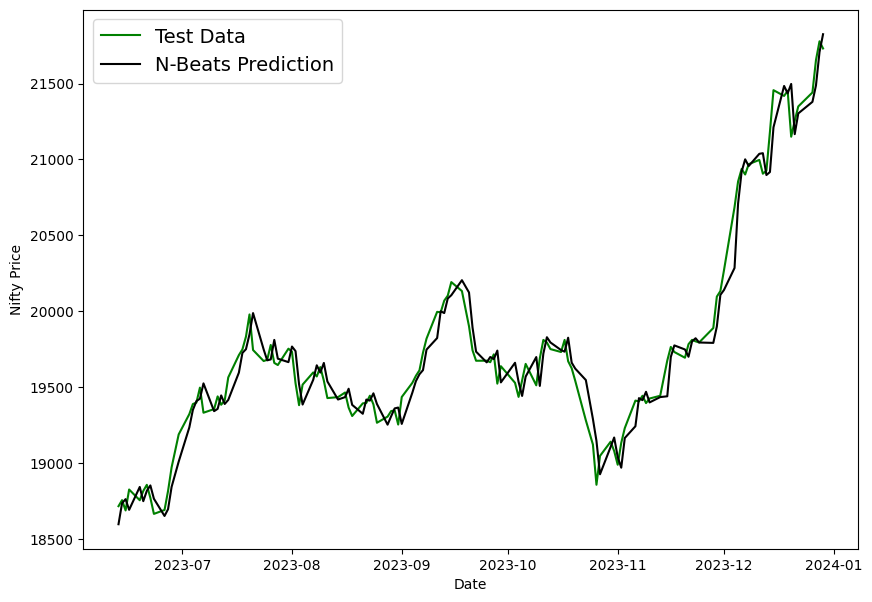

In [97]:
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], model_7_preds[offset:], "k-", label="N-Beats Prediction")
plt.xlabel("Date")
plt.ylabel("Nifty Price")

plt.legend(loc="upper left", fontsize=14);

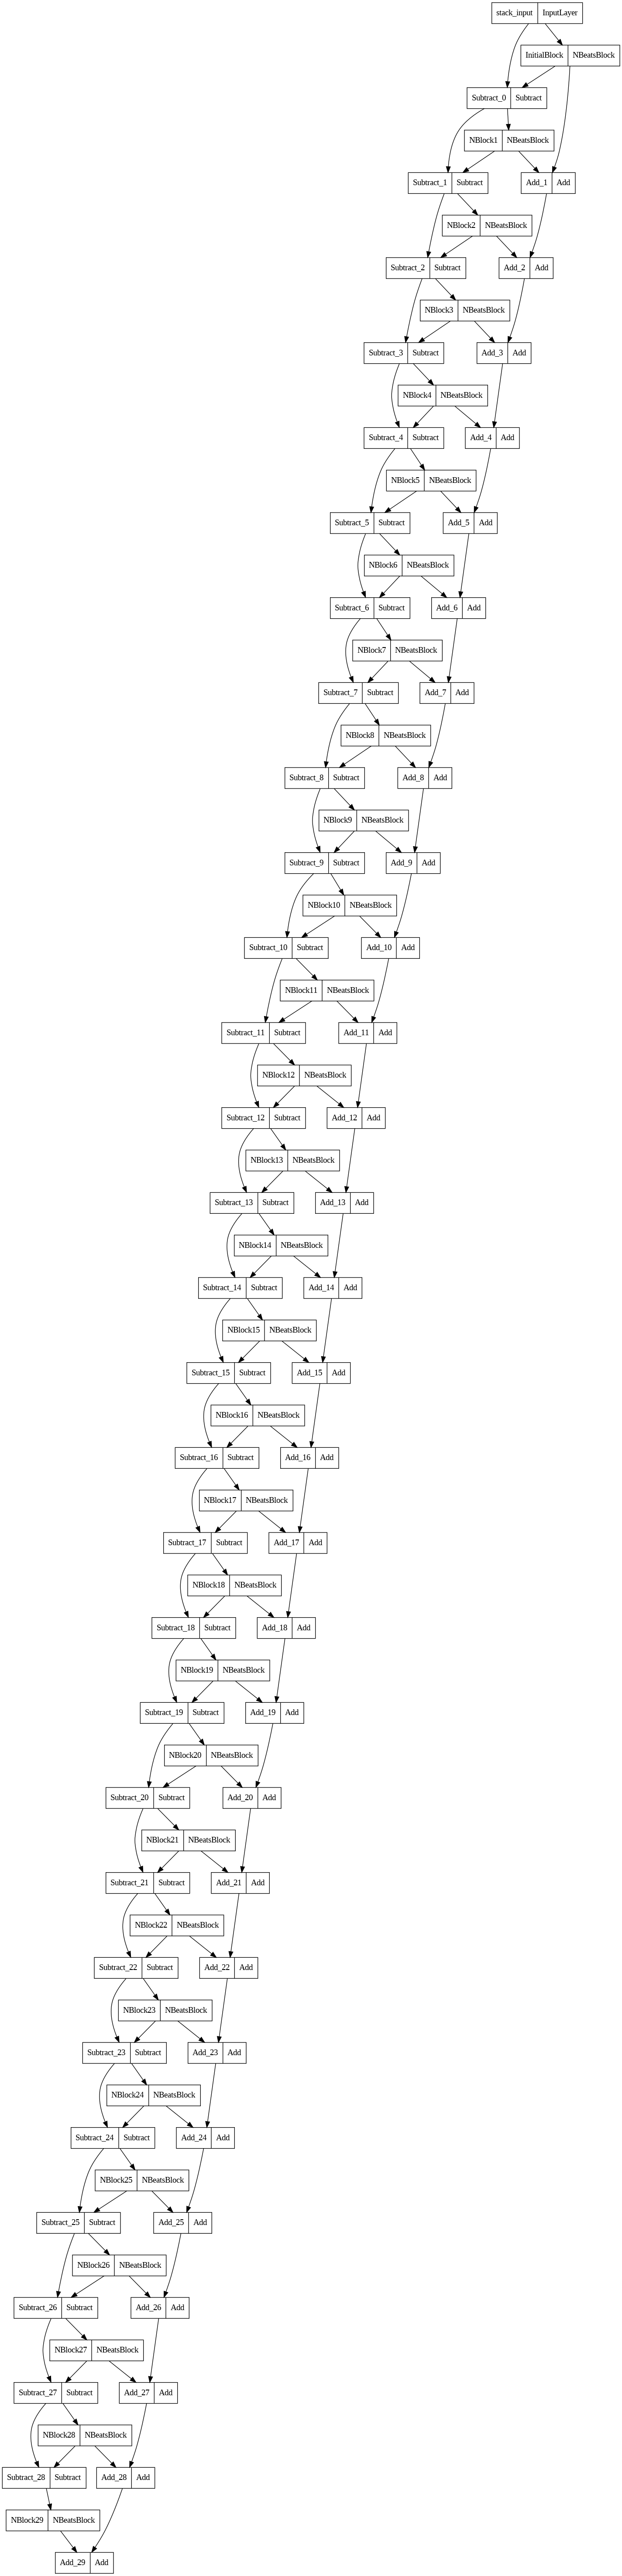

In [88]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Ensembling

In [89]:
def get_ensemble_models(horizon=HORIZON, train_data = train_dataset, test_data = test_dataset, num_iter = 10, num_epochs = 100, loss_fns=["mae", "mse", "mape"]):
  ensemble_models = []

  for i in range(num_iter):
    for lf in loss_fns:
      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])
      model.compile(loss=lf,optimizer=tf.keras.optimizers.Adam(),metrics=["mae", "mse"])
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      ensemble_models.append(model)

  return ensemble_models





In [90]:
ensemble_models = get_ensemble_models(num_iter=5,num_epochs=1000)


Epoch 104: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 407: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 105: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 787: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 887: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 130: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 629: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 225: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 581: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 681: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 217: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 206: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 191: ReduceLROnPlateau reducing l

In [91]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [92]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 45ms/step


<tf.Tensor: shape=(15, 636), dtype=float32, numpy=
array([[15794.8545, 15698.437 , 15706.864 , ..., 21570.309 , 21568.283 ,
        21742.188 ],
       [15770.01  , 15734.716 , 15735.771 , ..., 21402.715 , 21476.021 ,
        21596.754 ],
       [15758.806 , 15750.496 , 15638.186 , ..., 21474.078 , 21700.13  ,
        21830.305 ],
       ...,
       [15710.845 , 15747.081 , 15644.332 , ..., 21302.066 , 21554.143 ,
        21704.434 ],
       [15672.223 , 15810.216 , 15614.999 , ..., 21372.58  , 21715.541 ,
        21839.072 ],
       [15790.693 , 15743.76  , 15658.154 , ..., 21486.    , 21691.326 ,
        21805.027 ]], dtype=float32)>

In [93]:
import numpy as np
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 120.24642,
 'mse': 24774.635,
 'rmse': 157.3996,
 'mape': 0.6828061,
 'mase': 1.0505278}

In [94]:
def get_bound(preds):
  std = tf.math.reduce_std(preds,axis=0)
  interval = 1.96*std
  preds_mean = tf.reduce_mean(preds,axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

lower,upper = get_bound(preds=ensemble_preds)



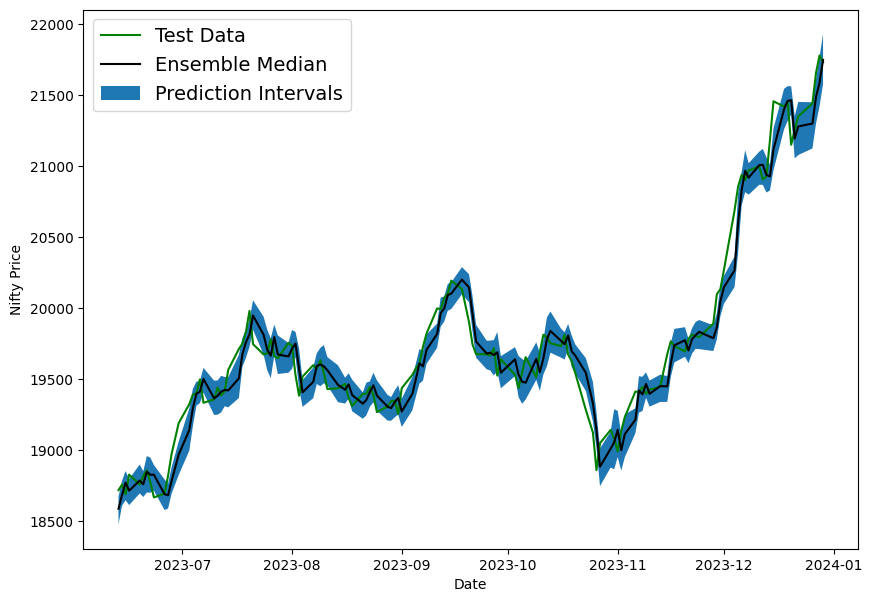

In [96]:
offset = 500
ensemble_median = np.median(ensemble_preds,axis=0)
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("Nifty Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);